# Mandelbrot's poisoned chalice

This is a shameless ripoff of an idea of Gabriel and Bernat
who used [chimera](https://www.cgl.ucsf.edu/chimera/)
to get an STL file from a multi image TIFF by stacking layers of voxels.
Below we build a TIFF for importing in Chimera.


Each level set is a Julia set with the corresponding $c$
in $f_c(z) = z^2 + c$ either:

- on a semicircle of radius  $\frac14$ centered at $0$
- on a segment between $-\frac14$ and $0$


Theoretically we can use Chimera directly from a notebook
with [this package](https://pypi.org/project/pychimera/0.1.11/)
but it only works with python 2.7 and I'm tired of building environments.


![chalice](./chalice.png)

if the image doesn't load [click here](https://github.com/macbuse/just-math/blob/master/chalice.png)

![chalice](./chalice2.jpg)

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import imageio 

# I might run this in notebook and not lab so
%matplotlib inline
# skimage is sensitive about letting u import so....
from skimage.transform import resize, rotate

def mk_gif(frames, fn='weather.gif', duration=.3):
    with imageio.get_writer(fn, mode='I',duration=duration) as writer:
        for frame in frames:
            if frame is None: continue
            writer.append_data(frame)
            

# Building the profile and a path in the Mandelbrot set

I gave up hand coding  the profile by hand and 

- wrote an extension  for **Inkscape** to export the SVG path 
- which is parsed  to an object with a parameterised 2D path
- which I can interpolate to get level sets

In [2]:
import json, os

fn = os.environ['HOME'] + '/cubic_bezier.json'
with open(fn,'r') as fp:
    data = json.load(fp)
   

1.0

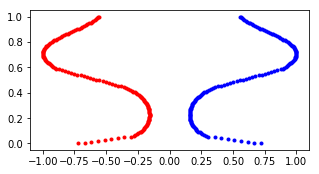

In [352]:
from svgpathtools import  parse_path

pth = data['svg']
pth = pth.replace(',', ' ')
bez = parse_path(pth)


num_layers = 150
T = np.linspace(0,1,num_layers)
myPath = [bez.point(t) for t in T]


X, Y = list(zip(* [(z.real,-z.imag) for z in reversed(myPath)] ))
X, Y = np.array(X), np.array(Y)

ff = abs((max(Y) - min(Y)) /(max(X) - min(X)))
# comment the next line out to see the design as is
ff = 1.
Y = (Y - min(Y))
Y =  Y/max(Y)
X = 1.04 - X/max(X)
X /= max(X)
            
R = [np.interp(t,Y,X) for t in T]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_aspect(1) 

ax.plot([-r for r in R], ff*T, 'r.')
ax.plot(R, ff*T, 'b.')

ff


![glass2.png](glass2.png)

# Let's improve the Julia sets we use


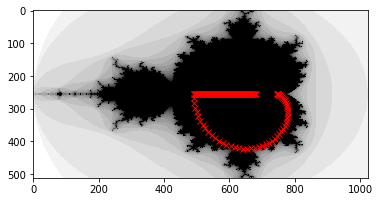

In [346]:
equator = .75
bottom = 0.4
base = 0

trans = .5*(equator + base)

def path_in_mandelbrot(t):
    
    def cardiod(z):
        return .5*z*(1-.5*z)
        
    if t < base:
        return .25

    if  t < trans : 
        tt = (t - base)/(trans-base)
        z = np.exp(np.pi*tt*1J)
        return cardiod(z)
    
    tt = (t - trans)/(1 - trans)
    return cardiod(-1)*(1 - tt) 

def z2pt(z):
    x =  z.real*256 + 1024/3*2
    y = z.imag*256 +256 
    return x,y

plt.imshow(image)
U,V = list(zip(* [z2pt(path_in_mandelbrot(t) ) for t in T]))
plt.plot(U,V,'rx')


# Code I had lying around 

this does the Mandelbrot set but you can get Julia sets by  a couple of small mods

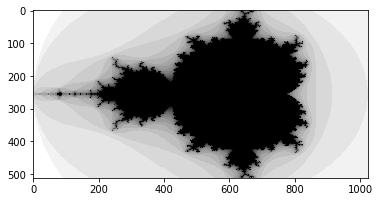

In [21]:
npts = 512
max_iter = 20

X = np.linspace(-2, 1, 2*npts)
Y = np.linspace(-1, 1, npts)

#broadcast the xs to a square array
C = X[:, None] + 1J*Y
#initial value is always zero
Z = np.zeros_like(C)

exit_times = max_iter * np.ones(C.shape, np.int8)
mask = exit_times > 0

for k in range(max_iter):
    Z[mask] = Z[mask] * Z[mask] + C[mask]
    mask, old_mask = abs(Z) < 2, mask
    #use XOR to detect the area which has changed 
    exit_times[mask ^ old_mask] = k
    
#r,g,b layers are all the same
image = np.stack((exit_times,)*3).T
#choose a coloring scheme now
image = 1 - image/max_iter

u = plt.imshow(image)
    

# Modded code

we need the Julia set code as a function to run on the path in the Mandelbrot set

In [332]:
def julia(C,
    npts = 512,
    max_iter = 20):

    X = np.linspace(-2, 2, npts)
    Y = np.linspace(-2, 2, npts)
    #broadcast the xs to a square array
    Z = X[:, None] + 1J*Y

    exit_times =  255 - np.zeros(Z.shape, np.uint8)
    mask = exit_times > 0

    for k in range(max_iter):
        Z[mask] = Z[mask] * Z[mask] + C
        mask = abs(Z) < 2
        exit_times[ np.logical_not(mask) ] = 0
    
    return exit_times
    

frames = [julia(.8*path_in_mandelbrot(t)) for t in T ]

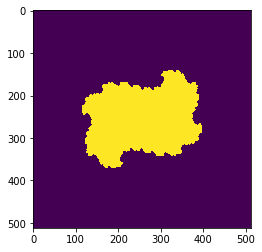

In [333]:
plt.imshow(frames[20])

# Now we need to do some post processing

resizing and a little rotation to get texture

In [323]:
def rebox(im,
          ss=.5,
          rr=10):

    '''change size and rotate a square image
    insert in the middle of a black image 
    of the same size as original'''
    
    sx, sy = im.shape
    
    #so I want to stay in uint8 so I preserve range
    layer = resize(im, (int(sx*ss), int(sy*ss)),  preserve_range=True)
    
    layer = rotate(layer, rr)
    
    dx, dy = layer.shape
    cx = sx//2 -  dx//2
    
    blk = np.zeros_like(im)
    #glue it in there baby
    blk[cx:cx + dx, cx:cx + dx] = layer[:]  
    im = np.stack((blk,)*3).T
    return im
          


## Output

we need to pad out the base so that it is solid
and save to a multi image TIFF

So I updated scikit image and all hell broke loose
but it turns out to be something stupid with the number of pages

In [336]:
ims = [ rebox(ff,r) for ff,r in zip(frames,R)]

# Warning

### fecking Chimera doesn't detect the number of pages/slices so you should set it fom this

In [341]:
len(ims)

150

### to get a rough idea of what's going on

In [343]:
imageio.mimwrite('pp.gif',ims)

### and output for chimera to process


imageio.mimwrite('glass3.tiff', ims,format='TIFF')